In [1]:
!pip install sentencepiece
!pip install datasets
!pip install subword-nmt
!pip install tokenizers

### Dataset 

In [2]:
from datasets import load_dataset

# Load the pre-processed dataset
dataset = load_dataset("stas/wmt14-en-de-pre-processed",verification_mode="no_checks")

/Users/ia4118/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(dataset['train']['translation'])

4548885

In [4]:
train_dataset = dataset['train']['translation']
val_dataset = dataset['validation']['translation']
test_dataset = dataset['test']['translation']

def create_file(dataset, file_name):
    with open(file_name + ".txt","w",encoding="utf-8") as f:
        for item in dataset:
            f.write('[DE] ' + item['de'] + '\n')
            f.write('[EN] ' + item['en'] + '\n')

create_file(train_dataset, "train")
create_file(val_dataset, "val")
create_file(test_dataset, "test")

### BPE Tokenizer

In [1]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=37000, show_progress=True, special_tokens=["[PAD]","[UNK]","[CLS]","[SEP]","[MASK]","[DE]","[EN]"], min_frequency=2, continuing_subword_prefix="@@")
tokenizer.train(files=["train.txt"], trainer=trainer)
tokenizer.save("tokenizer.json")

In [7]:
sentence = "Ich bin ein Berliner"
print(tokenizer.encode(sentence).ids)
print(tokenizer.encode(sentence).tokens)

[7072, 8397, 6671, 20789]
['Ich', 'bin', 'ein', 'Berliner']


### INPUT EMBEDDING

In [32]:
import torch.nn as nn
import torch
import numpy as np

#we need to move vocab size as a hardcode input

class InputEmbedding(nn.Module):
    """_summary_:Performs normalized embedddings. Returns N x d_k dimensions
    """
    def __init__(self, vocab_size, d_k):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_k = d_k
        #This will create hypervectors for the whole vocab_size with dimension d_k
        self.embedding = nn.Embedding(vocab_size, d_k)

    def forward(self, x):
        #the reason why we multiply by sqrt(d_k) is because we compute dot products of the embeddings
        #they would grow up very large so we need to normalize by d_k
        return self.embedding(x)*torch.sqrt(torch.tensor(self.d_k))

#N x d_k 
class PositionalEncoding(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #x is the input embedding
        pos = torch.arange(x.size(1)).unsqueeze(1)
        i = torch.arange(x.size(2))        
        print(pos.shape,i.shape)
        elements = pos/torch.pow(10000, 2*i/x.size(2))
        print(elements.shape)
        self.pe = torch.zeros(x.shape)
        self.pe[:,:,1::2] = torch.sin(elements[:,0::2])
        self.pe[:,:,0::2] = torch.cos(elements[:,1::2])
        
        return x + self.pe

IDs:  tensor([[ 7072,  8397,  6671, 20789]])
Embeddings:  torch.Size([1, 4, 10])
torch.Size([4, 1]) torch.Size([10])
torch.Size([4, 10])
Encodings torch.Size([1, 4, 10])


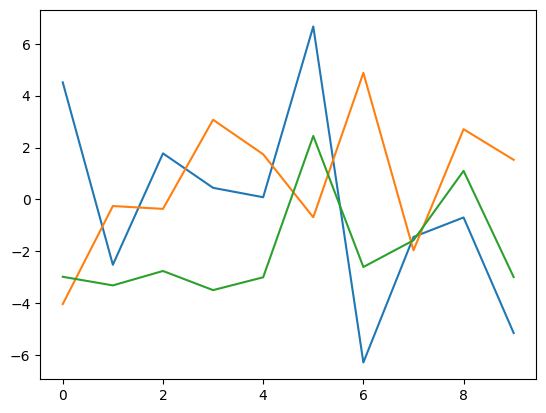

In [43]:
sentence = "Ich bin ein Berliner"
ids = tokenizer.encode(sentence).ids
ids = torch.tensor(ids).unsqueeze(0)
print("IDs: ", ids)
input_embedding = InputEmbedding(37000, 10)
embeddings = input_embedding(ids)
print("Embeddings: ", embeddings.shape)
positional_encoding = PositionalEncoding()
position_encoded = positional_encoding(embeddings)
print("Encodings",position_encoded.shape)
import matplotlib.pyplot as plt

plt.plot(position_encoded[0,0,:].detach().numpy())
plt.plot(position_encoded[0,1,:].detach().numpy())
plt.plot(position_encoded[0,2,:].detach().numpy())


### Encoder

In [ ]:
import pytorch

class MultiHeadAttention():
    """_summary_:Performs multihead
       _inputs_: input_embeddings
    """

class Encoder():
    

### Decoder